
<a href="https://colab.research.google.com/github/takzen/ai-engineering-handbook/blob/main/notebooks/056_Positional_Encoding_Transformer.ipynb" target="_parent">
    <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>



<a href="https://colab.research.google.com/github/takzen/ai-engineering-handbook/blob/main/56_Positional_Encoding_Transformer" target="_parent">
    <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


# 📍 Positional Encoding: GPS Transformera

Sieci rekurencyjne (LSTM) czytają słowo po słowie, więc "wiedzą", co było wcześniej.
Transformer czyta wszystko naraz (równolegle). **Nie ma poczucia czasu.**

Musimy sztucznie wstrzyknąć informację o pozycji.
Robimy to, DODAJĄC do wektora słowa specjalny wektor pozycyjny.

**Wzór z papieru "Attention Is All You Need":**
Autorzy wymyślili genialny sposób oparty na falach:
$$ PE_{(pos, 2i)} = \sin(pos / 10000^{2i/d_{model}}) $$
$$ PE_{(pos, 2i+1)} = \cos(pos / 10000^{2i/d_{model}}) $$

*   **pos:** Pozycja słowa w zdaniu (0, 1, 2...).
*   **i:** Indeks wymiaru w wektorze (0, 1, ... 512).

Dzięki temu każda pozycja ma unikalny "kod kreskowy", który model łatwo rozpoznaje.

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import math

# Konfiguracja
d_model = 512      # Rozmiar wektora (standard w GPT)
max_len = 100      # Maksymalna długość zdania

print(f"Tworzymy kodowanie dla zdania o długości {max_len} słów.")
print(f"Każde słowo ma {d_model} wymiarów.")

Tworzymy kodowanie dla zdania o długości 100 słów.
Każde słowo ma 512 wymiarów.


## Implementacja Matematyczna

Stworzymy klasę `PositionalEncoding`.
Zauważ, że `pe` (macierz kodowania) liczymy tylko raz i zapisujemy w pamięci (`register_buffer`). Nie jest to trenowalny parametr (nie zmienia się w trakcie nauki)! To stała matematyczna.

In [3]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        
        # Tworzymy macierz [max_len, d_model] wypełnioną zerami
        pe = torch.zeros(max_len, d_model)
        
        # Wektor pozycji [0, 1, 2, ..., max_len-1]
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        
        # Wektor dzielący (to skomplikowane 10000^(...))
        # Używamy exp(log) dla stabilności numerycznej
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        
        # Wypełniamy macierz sinusami (parzyste indeksy) i cosinusami (nieparzyste)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        # Dodajemy wymiar batcha [1, max_len, d_model]
        pe = pe.unsqueeze(0)
        
        # Zapisujemy jako bufor (nie parametr modelu - nie będzie trenowany przez gradient!)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x: [Batch, Seq_Len, d_model]
        # Dodajemy kodowanie do wejścia (przycinamy do długości aktualnego zdania)
        x = x + self.pe[:, :x.size(1)]
        return x

# Inicjalizacja
pos_encoder = PositionalEncoding(d_model=d_model, max_len=max_len)
print("Moduł gotowy.")

Moduł gotowy.


## Wizualizacja: Jak wygląda "Czas"?

To jest najciekawsza część. Narysujemy mapę ciepła (Heatmap) tej macierzy.
*   **Oś Y:** Pozycja słowa w zdaniu (od 0 do 100).
*   **Oś X:** Wymiary wektora (od 0 do 512).
*   **Kolor:** Wartość sinusa/cosinusa.

Powinieneś zobaczyć wzór, który wygląda jak psychodeliczna fala, rozciągająca się od lewej (szybkie zmiany) do prawej (wolne zmiany).

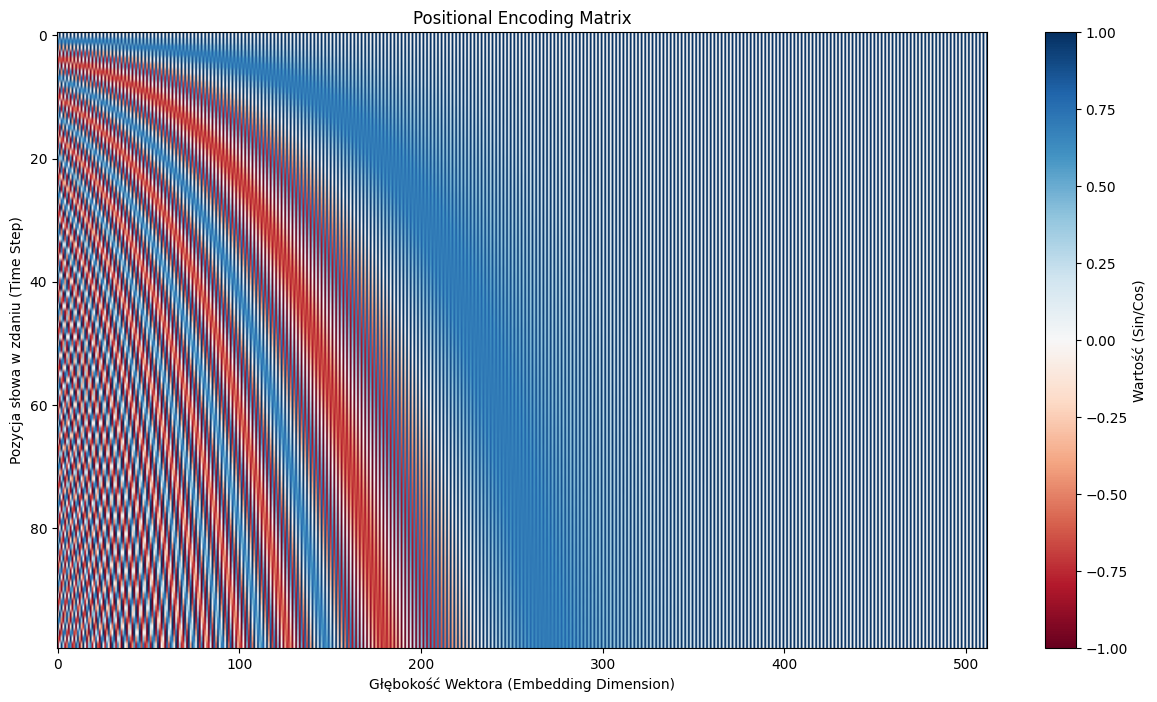

In [4]:
# Wyciągamy macierz z bufora
pe_matrix = pos_encoder.pe.squeeze().numpy()

plt.figure(figsize=(15, 8))
plt.imshow(pe_matrix, cmap='RdBu', aspect='auto')
plt.title("Positional Encoding Matrix")
plt.xlabel("Głębokość Wektora (Embedding Dimension)")
plt.ylabel("Pozycja słowa w zdaniu (Time Step)")
plt.colorbar(label="Wartość (Sin/Cos)")
plt.show()

## Analiza Fal

Dlaczego to wygląda tak dziwnie?
Spójrzmy na konkretne wymiary jako wykresy liniowe.

*   Wymiar 0 i 1 (początek wektora): Bardzo szybka fala.
*   Wymiar 40 i 41: Wolniejsza fala.
*   Wymiar 200: Bardzo powolna fala.

To działa jak zegar.
*   Wskazówka sekundowa (szybka) = niskie wymiary.
*   Wskazówka godzinowa (wolna) = wysokie wymiary.

Dzięki temu kombinacja wartości jest unikalna dla każdej sekundy (pozycji).

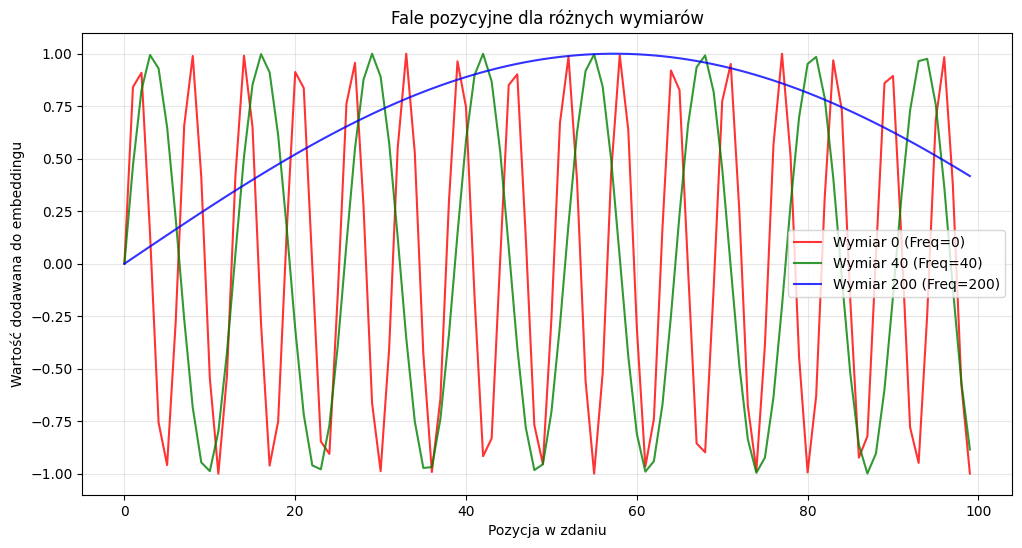

In [5]:
# Rysujemy wykresy dla wybranych wymiarów
plt.figure(figsize=(12, 6))

dimensions = [0, 40, 200] # Różne "częstotliwości"
colors = ['r', 'g', 'b']

for dim, color in zip(dimensions, colors):
    # Bierzemy kolumnę 'dim' dla wszystkich pozycji
    y_values = pe_matrix[:, dim]
    plt.plot(y_values, color=color, label=f'Wymiar {dim} (Freq={dim})', alpha=0.8)

plt.title("Fale pozycyjne dla różnych wymiarów")
plt.xlabel("Pozycja w zdaniu")
plt.ylabel("Wartość dodawana do embeddingu")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 🧠 Podsumowanie: Dodawanie zamiast Doklejania

Częste pytanie na rekrutacji: *"Dlaczego dodajemy (`+`) kodowanie pozycyjne do embeddingu słowa, zamiast dokleić je obok (`concat`)?"*

**Tu jest haczyk.**
1.  **Ekonomia:** Doklejanie zwiększyłoby rozmiar wektora (np. 512 + 512 = 1024). Sieć byłaby 2x cięższa.
2.  **Matematyka:** W wysokich wymiarach (np. 512D) wektory słów są "rzadkie". Dodanie do nich małych wartości (fal sinusa) nie niszczy informacji o znaczeniu słowa (np. "Król"), a jedynie lekko je "przesuwa" w przestrzeni.

Model uczy się, że:
*   Część sygnału to **znaczenie** (Słownik).
*   Część sygnału to **pozycja** (Gramatyka).

Dzięki temu GPT wie, że *"Zamek"* na początku zdania to podmiot, a na końcu to dopełnienie.